In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


## Read table
fname = 'vetting-v02'
fpath = f'../mnt/tess/labels/{fname}.csv'
all_table = pd.read_csv(fpath, header=0, low_memory=False).set_index('Astro ID')

## Rename or drop columns
all_table.drop(columns=['Split'])
all_table = all_table.rename(columns={'filename': 'File', 
                                      'Period': 'Per', 
                                      'Duration': 'Dur',
                                      'Transit_Depth': 'Depth',
                                      'star_rad': 'SRad',
                                      'star_rad_est': 'SRadEst',
                                      'star_mass': 'SMass',})

## Make label columns
disps = ['e', 'p', 'n', 'b', 't', 'u', 'j']
users = ['mk', 'ch', 'et', 'md', 'as', 'dm', 'Tansu', 'Shishir']
for d in disps:
    all_table[f'disp_{d}'] = 0

# Set all TOIs commented with "CP", "PC", or "KP" with the label 'pt'
tois_planet_mask = (all_table['comment'].str.contains("(PC)", regex=False).astype(bool) | all_table['comment'].str.contains("(CP)", regex=False).astype((bool)) | all_table['comment'].str.contains("(KP)", regex=False).astype((bool)))
# Print mismatches - not labelled planet by vetters, but is a TOI labelled KP, CP or PC (known planet, confirmed planet, planetary candidate)
print('Mismatches between TOI comment and vetting labels', all_table[tois_planet_mask][(all_table[tois_planet_mask]['Final'] != 'pt')]['TIC ID'])
all_table.loc[tois_planet_mask, 'Final'] = 'pt'


## Set labels
def set_labels(row):
    a = ~row.isna()
    if row['Final'] == 'i':
        # skip objects labeled as "inside the star"
        return row
    if a['Final']:
        row[f'disp_{row["Final"][0]}'] = 1
        row[f'disp_{row["Final"][1]}'] = 1
    else:
        for user in users:
            if a[user] and row[user]:
                row[f'disp_{row[user][0]}'] += 1
                row[f'disp_{row[user][1]}'] += 1

    return row

all_table = all_table.apply(set_labels, axis=1)

## Only use labelled rows 
print(f'Total entries: {len(all_table)}')
all_table = all_table[sum(all_table[f'disp_{d}'] for d in disps) > 0]
print(f'Total labeled entries: {len(all_table)}')

## And skip bad rows that have NaN in File', 'Per', 'Dur', 'Depth', or 'Tmag'
print("Skipping these TICs:", all_table[all_table[['File', 'Per', 'Dur', 'Depth', 'Tmag']].isna().any(axis=1)]['TIC ID'])
all_table = all_table[~all_table[['File', 'Per', 'Dur', 'Depth', 'Tmag']].isna().any(axis=1)]
print(f'Total after removing rows with missing File, Per, Dur, Depth, or Tmag: {len(all_table)}')


## Train-test split
t_train, t_test = train_test_split(all_table, test_size=0.1, random_state=42)
t_train, t_val = train_test_split(t_train, test_size=1./9, random_state=42)

## Print sizes of arrays and print duplicate counts
print(f'Split sizes. Train: {len(t_train)}; Valid: {len(t_val)}; Test: {len(t_test)}')
print(f'Duplicate TICs: {len(all_table.index.values) - len(set(all_table.index.values))}')
print('Splits')
print('  train:', len(t_train))
print('  val:', len(t_val))
print('  test:', len(t_test))

## Check label arrays
assert not any((t_train['disp_e'] + t_train['disp_p']+ t_train['disp_n'] + t_train['disp_b'] + t_train['disp_t'] + t_train['disp_u'] + t_train['disp_j']) == 0)
assert not any((t_val['disp_e'] + t_val['disp_p']+ t_val['disp_n'] + t_val['disp_b'] + t_val['disp_t'] + t_val['disp_u']+ t_val['disp_j']) == 0)
assert not any((t_test['disp_e'] + t_test['disp_p']+ t_test['disp_n'] + t_test['disp_b'] + t_test['disp_t'] + t_test['disp_u'] + t_test['disp_j']) == 0)

# ## Save train, test, and validation csv iles
# t_train.to_csv(f'../mnt/tess/astronet/tces-{fname}-tois_as_planets-train.csv')
# t_val.to_csv(f'../mnt/tess/astronet/tces-{fname}-tois_as_planets-val.csv')
# t_test.to_csv(f'../mnt/tess/astronet/tces-{fname}-tois_as_planets-test.csv')
# all_table.to_csv(f'../mnt/tess/astronet/tces-{fname}-tois_as_planets-all.csv')




Mismatches between TOI comment and vetting labels Astro ID
966      300217120
1260    1551168743
1261    1551168745
1270    1716106614
1447     391925531
           ...    
9336    1870990135
9337    1884091865
9341    1980725947
9342    1989628303
9344    2010186093
Name: TIC ID, Length: 4130, dtype: int64
Total entries: 9344
Total labeled entries: 8114
Skipping these TICs: Astro ID
966      300217120
1260    1551168743
1261    1551168745
1270    1716106614
1447     391925531
1529     408342294
1928     115131855
2017     129985650
2077     147934317
2186     177991747
2231     192551514
2256     201180053
2261     203036357
2312     215696184
2377     229609099
2464     240967708
2474     242425778
2501     249925249
2504     250608111
2526     256111905
2559     264614603
2590     271443727
2600     272624139
2653     282785238
2663     285233768
2675     288855848
2772     305891185
2773     305891240
2872     314543058
2905     317470446
3033     331934617
3064     335594365
3126 

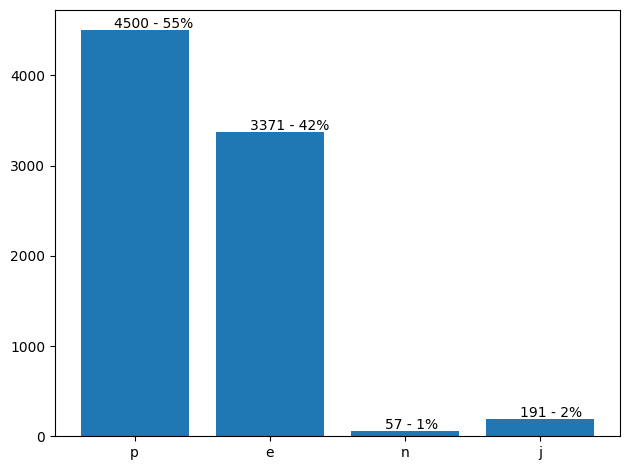

In [3]:
# Plot label distribution

from matplotlib import pyplot as plt
labels = ['p', 'e', 'n', 'j']

counts = [sum(all_table['disp_{}'.format(l)] > 0) for l in labels]
ax = plt.bar(labels, counts)
for i in range(len(labels)):
    b = ax[i]
    height = b.get_height()
    x, y = b.get_xy()
    plt.annotate(
        '{} - {:.0%}'.format(counts[i], counts[i] / sum(counts)),
        (x + 0.25, y + height + 20))
plt.tight_layout()

In [4]:
labels

['p', 'e', 'n', 'j']